In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
NUM_EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5])
])

dataset = datasets.MNIST("./data", transform=image_transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

In [4]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()

        ## encoder
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # decoder
        self.conv3 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, 3, padding=1)
        
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # encoder
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        # decoder
        x = self.upsample(x)
        x = self.relu(self.conv3(x))
        
        x = self.upsample(x)
        x = self.sigmoid(self.conv4(x))
        
        return x

In [5]:
model = AutoEncoder().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [6]:
def train(dataloader, model, optimizer, criterion):
    for epoch in range(NUM_EPOCHS):

        model.zero_grad()
        pbar = tqdm(dataloader, total=len(dataloader), position=0, desc="Training: ")
        for idx, data in enumerate(pbar):
            model.train()

            image, _ = data
            image = image.to(DEVICE)

            with torch.set_grad_enabled(True):
                output = model(image)
            loss = criterion(output, image)

            pbar.set_description(
                "[Training] [Epoch %d/%d] [Batch %d/%d] [loss: %.4f]"
                % (epoch + 1, NUM_EPOCHS, idx, len(dataloader), loss.item())
            )

            loss.backward()
            optimizer.step()

            model.zero_grad()

In [7]:
train(dataloader, model, optimizer, criterion)

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

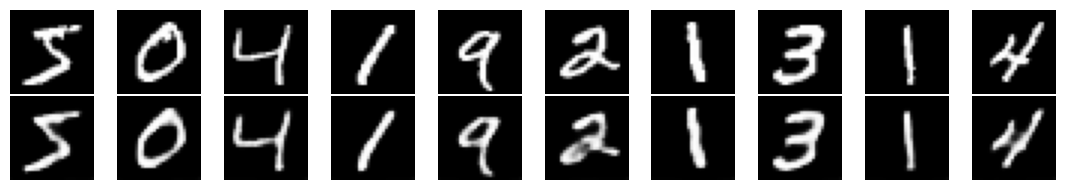

In [8]:
images, labels = next(iter(dataloader))
images = images.to(DEVICE)
outputs = model(images)

# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,0,:,:].cpu().detach().numpy(), cmap='gray')
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i,0,:,:].cpu().detach().numpy(), cmap='gray')
        axarr[row+1,col].axis('off')        
        i += 1
f.tight_layout(h_pad=0.2, w_pad=0.1)        
plt.show()